# Run anomaly detection

In [ ]:
# 1. Setup
%pip install -e .. -q
%load_ext autoreload
%autoreload 2

In [1]:
# 2. Load default config
from pathlib import Path

import pandas as pd

from metro_disruptions_intelligence.detect.streaming_iforest import StreamingIForestDetector

project_root = Path.cwd().parent

config_path = project_root / "configs" / "iforest_default.yaml"

**Note:** `StreamingIForestDetector` uses a default `subsample_size` of 256.
Running it on fewer observations (like the small example below) will
yield zero anomaly scores. For small samples you can pass a custom
configuration:
```python
from metro_disruptions_intelligence.detect import IForestConfig
det = StreamingIForestDetector(IForestConfig(subsample_size=50))
```

In [2]:
# 3. Choose processed features root
project_root = Path.cwd().parent
processed_root = project_root / "data" / "stations_features_time_series"

In [3]:
print(processed_root)

c:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\stations_features_time_series


The features should be stored in `data/stations_features_time_series` as described in the documentation.
If this directory is empty you must generate the Parquet files first.

In [7]:
# 4a. Train detector on stored feature files and save model
from datetime import datetime, timedelta

train_start = datetime(2025, 3, 6, 16, 50)
train_end = train_start + timedelta(hours=2)
det = StreamingIForestDetector(config_path)
for ts in range(int(train_start.timestamp()), int(train_end.timestamp()), 60):
    dt = datetime.fromtimestamp(ts)
    p = (
        processed_root
        / f"year={dt.year:04d}"
        / f"month={dt.month:02d}"
        / f"day={dt.day:02d}"
        / f"stations_feats_{dt:%Y-%d-%m-%H-%M}.parquet"
    )
    if not p.exists():
        continue
    df = pd.read_parquet(p)
    det.score_and_update(df)
det.save("iforest_model.pkl")

In [8]:
# 4. Stream 2 hours of feature data
import json
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

start = datetime(2025, 3, 6, 16, 50)
end = start + timedelta(hours=2)
rows = []
det = StreamingIForestDetector(config_path)
for ts in range(int(start.timestamp()), int(end.timestamp()), 60):
    dt = datetime.fromtimestamp(ts)
    f = (
        processed_root
        / f"year={dt.year:04d}"
        / f"month={dt.month:02d}"
        / f"day={dt.day:02d}"
        / f"stations_feats_{dt:%Y-%d-%m-%H-%M}.parquet"
    )
    if not f.exists():
        continue
    df = pd.read_parquet(f)
    out = det.score_and_update(df, explain=True)
    rows.append(out)
scores = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

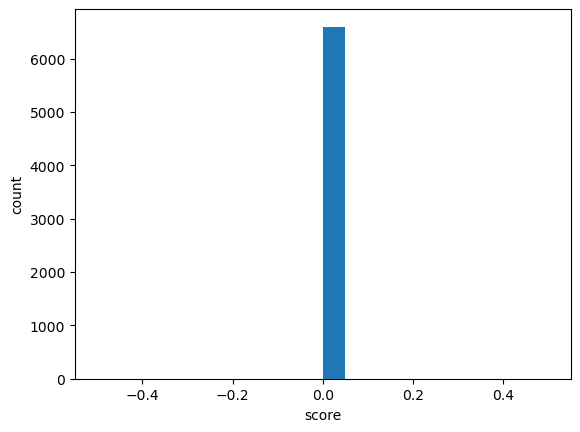

In [9]:
# 5. Histogram of anomaly_score
plt.hist(scores["anomaly_score"], bins=20)
plt.xlabel("score")
plt.ylabel("count");

In [10]:
# 6. Top-10 anomalies with SHAP explanations
top10 = scores.nlargest(10, "anomaly_score").copy()
top10["shap_top3"] = top10["shap_top3_json"].apply(json.loads)
top10[["ts", "stop_id", "anomaly_score", "shap_top3"]]

,ts,stop_id,anomaly_score,shap_top3
0,1741279800,2000465,0.0,"[[arrival_delay_t, 0], [departure_delay_t, 0],..."
1,1741279800,2153403,0.0,"[[arrival_delay_t, 0], [departure_delay_t, 0],..."
2,1741279800,2000467,0.0,"[[arrival_delay_t, 0], [departure_delay_t, 0],..."
3,1741279800,2000461,0.0,"[[arrival_delay_t, 0], [departure_delay_t, 0],..."
4,1741279800,2155266,0.0,"[[arrival_delay_t, 0], [departure_delay_t, 0],..."
5,1741279800,2000462,0.0,"[[arrival_delay_t, 0], [departure_delay_t, 0],..."
6,1741279800,2017077,0.0,"[[arrival_delay_t, 0], [departure_delay_t, 0],..."
7,1741279800,2155268,0.0,"[[arrival_delay_t, 0], [departure_delay_t, 0],..."
8,1741279800,2067143,0.0,"[[arrival_delay_t, 0], [departure_delay_t, 0],..."
9,1741279800,2000463,0.0,"[[arrival_delay_t, 0], [departure_delay_t, 0],..."


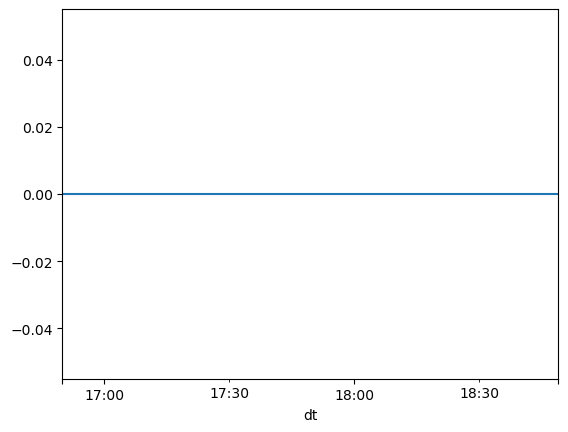

In [11]:
# 7. Mean anomaly_score over time
scores["dt"] = pd.to_datetime(scores["ts"], unit="s")
mean_series = scores.groupby("dt")["anomaly_score"].mean()
mean_series.plot();

In [ ]:
# 8. Tune hyper-parameters via CLI
!poetry run mdi tune-iforest \
+        --processed-root data/stations_features_time_series \
+        --start 2023-05-01T00:00:00Z \
+        --end 2023-05-01T02:00:00Z
print(Path("iforest_best.yaml").read_text())